In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt 

reconstruction_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/BaselineUNet/Epoch48/reconstructions_grappa_input/'
GT_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/'
file = 'file_brain_AXFLAIR_201_6002884.h5'
## Too dark
#file = 'file_brain_AXT1_202_2020225.h5'
## R = 8
#file = 'file_brain_AXFLAIR_200_6002441.h5'

GT_path = os.path.join(GT_path,file)
reconstruction_path = os.path.join(reconstruction_path,file)

GT = h5py.File(GT_path,'r')
reconstruction = h5py.File(reconstruction_path,'r')


In [2]:
def calculate_R(filename):
    mask_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_test/'
    mask = h5py.File(os.path.join(mask_path,filename),'r')
    nPE_mask = mask['mask'][()]
    sampled_columns = np.sum(nPE_mask)
    R = len(nPE_mask)/sampled_columns
    return R


In [3]:
GT = GT['reconstruction_rss']
reconstruction = reconstruction['reconstruction']


In [4]:
GT = np.array(GT)
reconstruction = np.array(reconstruction)


In [5]:
slice = 3


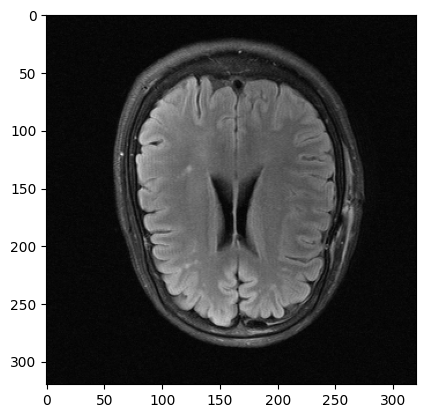

In [6]:
# Ground truth
plt.imshow(GT[slice,:,:],cmap='gray')


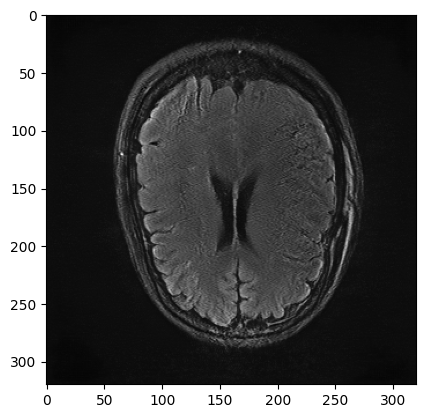

In [7]:
# Epoch 48
plt.imshow(reconstruction[slice,:,:],cmap='gray')


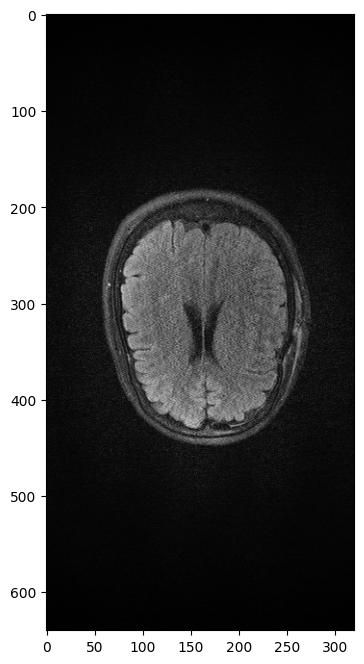

In [9]:
# View input of the model

input_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/'
input_path = os.path.join(input_path,file)
input = h5py.File(input_path,'r')
input_kspace = input['grappa_data'][()]

import fastmri
from fastmri.data import transforms as T
input_kspace_T = T.to_tensor(input_kspace)    
sampled_image_T = fastmri.ifft2c(input_kspace_T)
sampled_image_abs = fastmri.complex_abs(sampled_image_T)
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=1)

plt.figure(figsize=(12,8))
plt.imshow(np.abs(sampled_image_rss[slice,:,:].numpy()), cmap='gray')


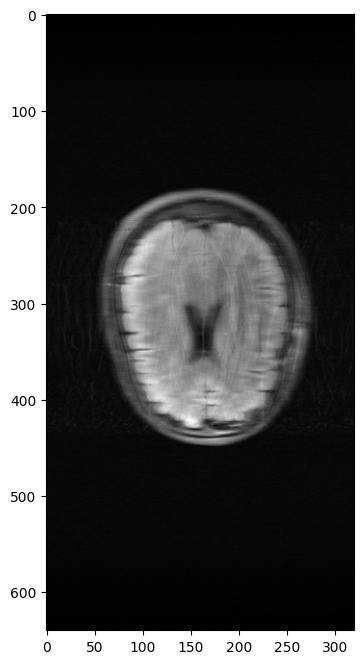

In [10]:
# View on what type of image the model was trained

input_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/'
input_path = os.path.join(input_path,file)
input = h5py.File(input_path,'r')
input_kspace = input['kspace'][()]

import fastmri
from fastmri.data import transforms as T
input_kspace_T = T.to_tensor(input_kspace)    
sampled_image_T = fastmri.ifft2c(input_kspace_T)
sampled_image_abs = fastmri.complex_abs(sampled_image_T)
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=1)

plt.figure(figsize=(12,8))
plt.imshow(np.abs(sampled_image_rss[slice,:,:].numpy()), cmap='gray')


In [11]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from typing import Optional

def nmse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Normalized Mean Squared Error (NMSE)"""
    return np.array(np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2)

def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)

def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]


In [12]:
# Baseline model

print(nmse(GT,reconstruction))
print(psnr(GT,reconstruction))
print(ssim(GT,reconstruction))


0.08738877102141479
24.66171268764104
[0.71503648]
